In [3]:
## Importing required packages
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Dense
from keras.layers import RNN
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import GRU
from keras.layers import SimpleRNN, Dropout
import datetime
import time
from datetime import timedelta

import os
import psutil
from pandas import concat

## Preload data and preprocess

In [2]:
#loading the original data
data = pd.read_csv('datasets/household_power_consumption.csv', sep=';')

C:\Users\pc1\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
# original data set
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
# Combining date and time 
data['date_time'] = pd.to_datetime(data['Date'] + ' ' + data['Time'] )

In [5]:
# replacing "?" with nan
data = data.replace(['?'], np.nan)
# converting 'Global_active_power' to numeric data type
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')
# replacing NaN values of Global_active_power with the mean of the column
data['Global_active_power'].fillna(float(data['Global_active_power'].mean()), inplace=True)

In [6]:
# extract the two columns ['date_time', 'Global_active_power']
data = data.loc[:, ['date_time', 'Global_active_power']]
data.sort_values('date_time', inplace=True, ascending=True)
data = data.reset_index(drop=True)
#set 'date_time' as an index
data.set_index('date_time', inplace=True)

In [7]:
# resample the data into hours as opposed to minutes
data = data.resample('H').sum()

In [8]:
data.head()

,Global_active_power
date_time,
2006-12-16 17:00:00,152.024
2006-12-16 18:00:00,217.932
2006-12-16 19:00:00,204.014
2006-12-16 20:00:00,196.114
2006-12-16 21:00:00,183.388


### Divide the data in to train and test

In [9]:
# Extract two yerars data for training 
df_train = data.loc['2007-01-01':'2008-12-31',]['Global_active_power']
data_train = df_train.to_frame()

In [10]:
data_train.head()

,Global_active_power
date_time,
2007-01-01 00:00:00,153.038
2007-01-01 01:00:00,151.404
2007-01-01 02:00:00,154.940
2007-01-01 03:00:00,152.500
2007-01-01 04:00:00,148.544


Text(0.5, 0, 'Date')

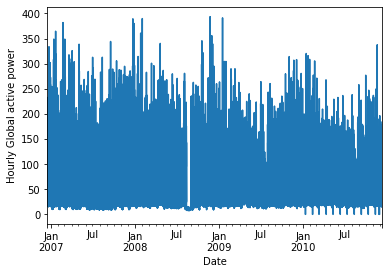

In [11]:
# visualization of train data
data['Global_active_power'].plot()

plt.ylabel('Hourly Global active power')
plt.xlabel('Date')

In [12]:
# write the training data to disk as a csv file for later use
df_train.to_csv('datasets/cleaned_household_power_consumption_train.csv')

In [13]:
#Extract  one month test data
data_test_a = data.loc['2009-01-01':'2009-01-31',]['Global_active_power']
data_test_1 = data_test_a.to_frame()

In [14]:
data_test_1.head()

,Global_active_power
date_time,
2009-01-01 00:00:00,32.096
2009-01-01 01:00:00,32.428
2009-01-01 02:00:00,34.522
2009-01-01 03:00:00,31.590
2009-01-01 04:00:00,31.314


Text(0.5, 0, 'One Month')

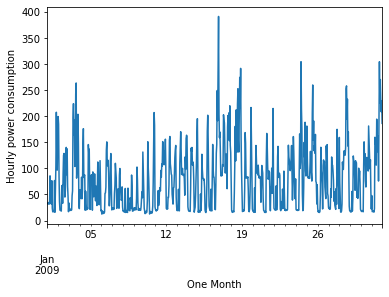

In [15]:
# visualization of 1 month test set
data_test_1['Global_active_power'].plot()
plt.ylabel('Hourly power consumption')
plt.xlabel('One Month')


In [16]:
# write the one month test data to disk as a csv file for later use
data_test_1.to_csv('datasets/cleaned_household_power_consumption_data_test_1.csv')

## Memory and CPU Utilization Measurement tool

In [4]:
mem_dic = {}
cpu_dic = {}

def measureit(func):
    """
    Measures a function's memory usage and running time.
    """
    pid = os.getpid()
    ps = psutil.Process(pid)
    
    start_mem = ps.memory_info().rss/1024**2
    start_cpu_time = ps.cpu_percent()
    
    def measure_mem_cpu(*args, **kw):
        
        result = func(*args, **kw)
        
        end_cpu_time = ps.cpu_percent()
        
        mem = ps.memory_info().rss/1024**2 - start_mem
        cpu = end_cpu_time - start_cpu_time
        
        
        dic_key = func.__qualname__
        mem_dic.update({dic_key:mem})
        cpu_dic.update({dic_key:cpu})
        

        print("Memory usage of %s(): %.2f MB." % (func.__qualname__, mem))
        print("Processing cpu time of %s(): %.0f seconds." % (func.__qualname__, cpu))
        return result

    return measure_mem_cpu
        

def prep_cpu_mem_df():
    
    mem_df = pd.DataFrame(list(zip(mem_dic.keys(), mem_dic.values())),
                   columns =['Model', 'Val'])
    cpu_df = pd.DataFrame(list(zip(cpu_dic.keys(), cpu_dic.values())),
                   columns =['Model', 'Val'])
    
    return mem_df, cpu_df

## Reusable Data and Functions

In [5]:
df_train = pd.read_csv('datasets/cleaned_household_power_consumption_train.csv', usecols=[1], engine='python')
df_train.size

17544

In [6]:
data_test_1 = pd.read_csv('datasets/cleaned_household_power_consumption_data_test_1.csv', usecols=[1], engine='python')
data_test_1.size

744

In [7]:
# appendig test dataframe on training dataframe for use in different models
df1 = df_train.append(data_test_1, ignore_index=True, sort=False)


In [8]:
# constants which will be used by all models 

look_back = 30

In [9]:
# transform dataframe using scaler
def normalize_df(data_frame):
    dataset = scaler.fit_transform(data_frame)
    return dataset

In [10]:
# divide the dataframe into train and test
def split_to_train_and_test(dataset):
    train, test = dataset[0:df_train.size:], dataset[df_train.size:len(dataset):]
    return train, test

In [11]:
# convert an array of values into a dataset matrix
def create_dataset(dataset):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    #print("Inside create dataset", dataX, dataY)
    return np.array(dataX), np.array(dataY)

In [12]:
# reshape input to be [samples, time steps, features]
def reshape_input(train, test):
    trainX, trainY = create_dataset(train)
    testX, testY = create_dataset(test)
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    print("inside reshape dataset",trainX.shape, trainY.shape, testX.shape, testY.shape )
    return trainX, trainY, testX, testY

In [13]:
def make_predictions(model, trainX, testX):
    
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    return trainPredict, testPredict
    

In [14]:
def invert_predictions(model, trainX, trainY, testX):
    trainPredict, testPredict = make_predictions(model, trainX, testX)
     
    train_predict = scaler.inverse_transform(trainPredict)
    train_y = scaler.inverse_transform([trainY])
    test_predict = scaler.inverse_transform(testPredict)
    
    return train_predict, train_y, test_predict
    

In [15]:
def plot_predictions(dataset, trainPredict, testPredict):
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    
    # plot baseline and predictions
    fig= plt.figure(figsize=(15,8))
    power_changes=fig.add_subplot(1,1,1)
    power_changes.set_ylabel('Consumed power')
    power_changes.set_xlabel('Hours')

    power_changes.plot(scaler.inverse_transform(dataset), color='blue', label='Real power')
    power_changes.plot(trainPredictPlot, color= 'orange', label='Train Predictions')
    power_changes.plot(testPredictPlot, color= 'Green', label='Test Predictions')
    power_changes.set_title('Real consumption power versus predictions by SVR using timeseries data ')
    power_changes.legend(loc='best')
    
    

In [16]:
#dataset with one month test data
dataset = df1

In [17]:
d = df1['Global_active_power'].values

In [18]:
# mean of the dataset
d.mean()

66.2211870811391

In [19]:
# standard devation of the dataset
import statistics

print("Standard Deviation of df1 is % s "
      % (statistics.stdev(d)))

Standard Deviation of df1 is 57.303972419572375 


### SVR

In [30]:
# split and convert to dataset matrix
train_data, test_data = split_to_train_and_test(dataset) 
trainX, trainY = create_dataset(train_data.values) 
testX, testY = create_dataset(test_data.values) 
print("Train and test data after converting to supervised", trainX.shape,trainY.shape, testX.shape, testY.shape )

Train and test data after converting to supervised (17519, 24) (17519,) (719, 24) (719,)


In [31]:
# Scale the trainX and reshape trainY and after that normalized trainY, only normalized testX 
scaler_svr=MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_svr.fit_transform(trainX)
print("X_train_scaled shape after scaling by minmax scaler", X_train_scaled.shape)
print("Y_train shape after scaling by minmax scaler", trainY.shape)
X_test_scaled = scaler_svr.transform(testX)
print("X_test_scaled shape after scaling by minmax scaler", X_test_scaled.shape)
# did not normalized testY

X_train_scaled shape after scaling by minmax scaler (17519, 24)
Y_train shape after scaling by minmax scaler (17519,)
X_test_scaled shape after scaling by minmax scaler (719, 24)


In [32]:
# convert windows of hourly data into a series of total power
def to_series(data):
    series = np.array(data).flatten()
    return series

In [33]:
@measureit
def svr_model(train_X_scaled, trainY):
    svr_rbf = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.1)
    svr_rbf.fit(train_X_scaled, trainY)
    return svr_rbf
    

In [34]:
# svr model and fit: memory usage and processing cpu time is varying
svr_m = svr_model(X_train_scaled,trainY)
yhat_sequence=svr_m.predict(X_test_scaled)


Memory usage of svr_model(): 5.66 MB.
Processing cpu time of svr_model(): 100 seconds.


In [35]:
print("predictions on X_test_scaled", yhat_sequence.shape, testY.shape)

predictions on X_test_scaled (719,) (719,)


In [36]:
predictions=to_series(yhat_sequence)
test_data=to_series(testY)

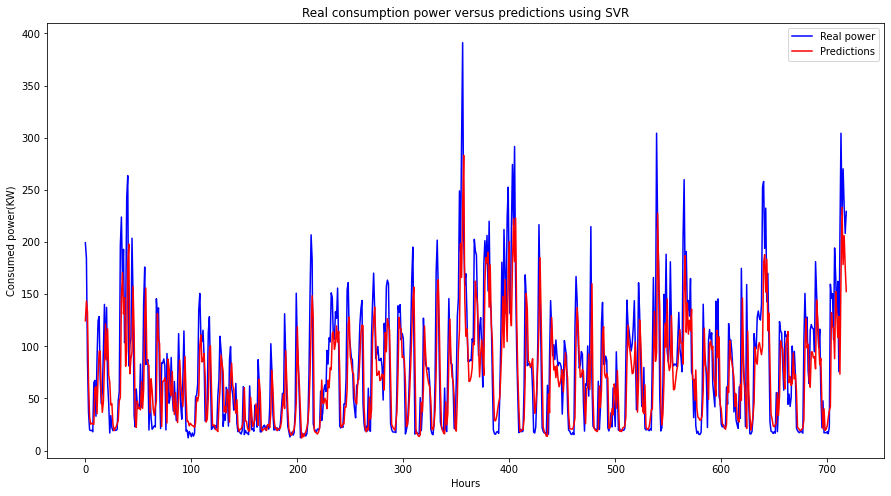

In [37]:
#visualization of Real power consumption  versus predictions by SVR using one month test data
fig= plt.figure(figsize=(15,8))
power_changes=fig.add_subplot(1,1,1)
power_changes.set_ylabel('Consumed power(KW)')
power_changes.set_xlabel('Hours')

power_changes.plot(test_data, color='blue', label='Real power')
power_changes.plot(predictions, color= 'red', label='Predictions')
power_changes.set_title('Real consumption power versus predictions using SVR')
power_changes.legend(loc='best')

In [38]:
#Calculating RMSE
def print_scores(y_test,y_pred):
    rmse= np.sqrt(mean_squared_error(y_test,y_pred))    
    return rmse
rmse=print_scores(predictions,test_data)
print(rmse)

40.898533648082974


### ANN

In [39]:

print("Train and test data after converting to supervised", trainX.shape,trainY.shape, testX.shape, testY.shape )

Train and test data after converting to supervised (17519, 24) (17519,) (719, 24) (719,)


In [40]:

scaler_ann = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_ann = scaler_ann.fit_transform(trainX)
print("X_train_scaled shape after scaling by minmax scaler", X_train_scaled_ann.shape)
trainY=np.reshape(trainY,(trainY.size, 1))
Y_train_scaled_ann= scaler_ann.fit_transform(trainY)
print("Y_train_scaled shape after scaling by minmax scaler", Y_train_scaled_ann.shape)

X_test_scaled_ann = scaler_ann.transform(testX)
print("X_train_scaled shape after scaling by minmax scaler", X_test_scaled_ann.shape)


X_train_scaled shape after scaling by minmax scaler (17519, 24)
Y_train_scaled shape after scaling by minmax scaler (17519, 1)
X_train_scaled shape after scaling by minmax scaler (719, 24)


In [41]:
#ANN Model

@measureit
def ann_model(num_neurons_1,X, y, verbose=2):
    model_ann = Sequential()
    # define number of input variables and the hidden layer
    model_ann.add(Dense(num_neurons_1, input_dim= X.shape[1], activation='relu'))
    # add another layer
    model_ann.add(Dense(20, kernel_initializer='normal', activation='relu'))
    # create output layer
    model_ann.add(Dense(1, kernel_initializer='normal'))
    model_ann.compile(loss='mean_squared_error', optimizer='adam')
    # fit the model on the training set
    model_ann.fit(X, y, epochs=50, batch_size=32, verbose=verbose)
    return model_ann
    
    
    
#number of neurons in the hidden layer
num_neurons_1= 10
model_ann=ann_model(num_neurons_1,X_train_scaled_ann, Y_train_scaled_ann)

Epoch 1/50
548/548 - 1s - loss: 0.0145
Epoch 2/50
548/548 - 0s - loss: 0.0099
Epoch 3/50
548/548 - 0s - loss: 0.0098
Epoch 4/50
548/548 - 0s - loss: 0.0096
Epoch 5/50
548/548 - 0s - loss: 0.0096
Epoch 6/50
548/548 - 0s - loss: 0.0096
Epoch 7/50
548/548 - 0s - loss: 0.0095
Epoch 8/50
548/548 - 0s - loss: 0.0095
Epoch 9/50
548/548 - 0s - loss: 0.0095
Epoch 10/50
548/548 - 0s - loss: 0.0095
Epoch 11/50
548/548 - 0s - loss: 0.0095
Epoch 12/50
548/548 - 0s - loss: 0.0095
Epoch 13/50
548/548 - 0s - loss: 0.0095
Epoch 14/50
548/548 - 0s - loss: 0.0094
Epoch 15/50
548/548 - 0s - loss: 0.0094
Epoch 16/50
548/548 - 0s - loss: 0.0094
Epoch 17/50
548/548 - 0s - loss: 0.0094
Epoch 18/50
548/548 - 0s - loss: 0.0094
Epoch 19/50
548/548 - 0s - loss: 0.0094
Epoch 20/50
548/548 - 0s - loss: 0.0093
Epoch 21/50
548/548 - 0s - loss: 0.0093
Epoch 22/50
548/548 - 0s - loss: 0.0093
Epoch 23/50
548/548 - 0s - loss: 0.0093
Epoch 24/50
548/548 - 0s - loss: 0.0093
Epoch 25/50
548/548 - 0s - loss: 0.0093
Epoch 26/

In [42]:
testPredict=model_ann.predict(X_test_scaled)
print(testPredict.shape) #printed scaled predicted values

(719, 1)


# Invert predictions and test dataset

In [43]:

inv_yhat = scaler_ann.inverse_transform(testPredict)

predictions=to_series(inv_yhat)
test_data=to_series(testY)


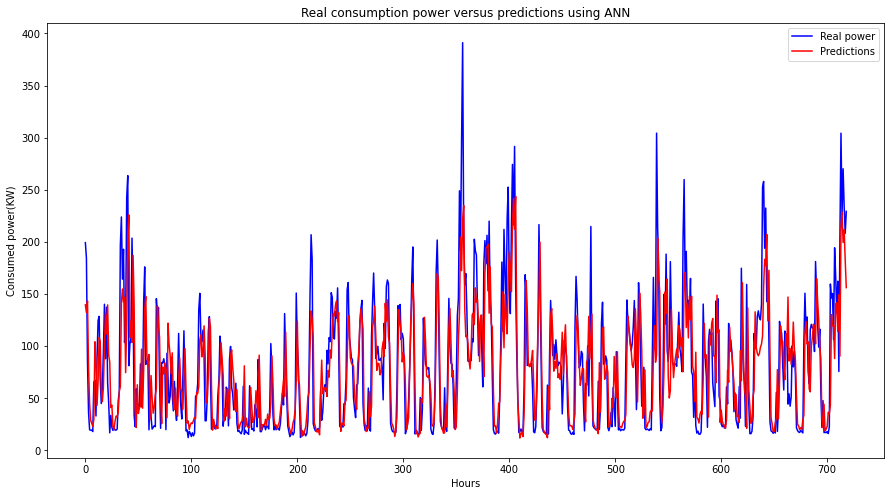

In [44]:
#visualization of Real power consumption  versus predictions by ANN using one month test data
fig= plt.figure(figsize=(15,8))
power_changes=fig.add_subplot(1,1,1)
power_changes.set_ylabel('Consumed power(KW)')
power_changes.set_xlabel('Hours')

power_changes.plot(test_data, color='blue', label='Real power')
power_changes.plot(predictions, color= 'red', label='Predictions')
power_changes.set_title('Real consumption power versus predictions using ANN')
power_changes.legend(loc='best')

In [45]:
#Calculating RMSE
def print_scores(y_test,y_pred):
    rmse= np.sqrt(mean_squared_error(y_test,y_pred))    
    return rmse
rmse=print_scores(predictions,test_data)
print(rmse)

39.502684241815885


### RNN

In [83]:

scaler_rnn = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_rnn = scaler_rnn.fit_transform(trainX)
print("X_train_scaled shape after scaling by minmax scaler", X_train_scaled_rnn.shape)

Y_train_scaled_rnn= scaler_rnn.fit_transform(trainY)
print("Y_train_scaled shape after scaling by minmax scaler", Y_train_scaled_rnn.shape)

X_test_scaled_rnn = scaler_rnn.transform(testX)
print("X_train_scaled shape after scaling by minmax scaler", X_test_scaled_rnn.shape)

trainX_re = np.reshape(X_train_scaled_rnn, (X_train_scaled_rnn.shape[0], 1, X_train_scaled_rnn.shape[1]))
testX_re = np.reshape(X_test_scaled_rnn, (X_test_scaled_rnn.shape[0], 1, X_test_scaled_rnn.shape[1]))

print(trainX_re.shape, testX_re.shape)


X_train_scaled shape after scaling by minmax scaler (17519, 24)
Y_train_scaled shape after scaling by minmax scaler (17519, 1)
X_train_scaled shape after scaling by minmax scaler (719, 24)
(17519, 1, 24) (719, 1, 24)


In [84]:
# SimpleRNN model
@measureit
def rnn_model():
    model = Sequential()
    model.add(SimpleRNN(units=32, input_shape=(1,look_back), activation="relu"))
    model.add(Dense(8, activation="relu")) 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='Adam')
    
    model.fit(trainX_re,Y_train_scaled_rnn, epochs=100, batch_size=32, verbose=2)
    return model

In [85]:

rnn_mod = rnn_model()

Epoch 1/100
548/548 - 1s - loss: 0.0176
Epoch 2/100
548/548 - 0s - loss: 0.0100
Epoch 3/100
548/548 - 0s - loss: 0.0097
Epoch 4/100
548/548 - 0s - loss: 0.0096
Epoch 5/100
548/548 - 0s - loss: 0.0095
Epoch 6/100
548/548 - 0s - loss: 0.0094
Epoch 7/100
548/548 - 0s - loss: 0.0094
Epoch 8/100
548/548 - 0s - loss: 0.0094
Epoch 9/100
548/548 - 0s - loss: 0.0093
Epoch 10/100
548/548 - 1s - loss: 0.0093
Epoch 11/100
548/548 - 0s - loss: 0.0093
Epoch 12/100
548/548 - 0s - loss: 0.0092
Epoch 13/100
548/548 - 0s - loss: 0.0092
Epoch 14/100
548/548 - 0s - loss: 0.0092
Epoch 15/100
548/548 - 0s - loss: 0.0091
Epoch 16/100
548/548 - 0s - loss: 0.0091
Epoch 17/100
548/548 - 0s - loss: 0.0091
Epoch 18/100
548/548 - 0s - loss: 0.0091
Epoch 19/100
548/548 - 0s - loss: 0.0091
Epoch 20/100
548/548 - 0s - loss: 0.0091
Epoch 21/100
548/548 - 0s - loss: 0.0090
Epoch 22/100
548/548 - 0s - loss: 0.0090
Epoch 23/100
548/548 - 0s - loss: 0.0090
Epoch 24/100
548/548 - 0s - loss: 0.0090
Epoch 25/100
548/548 - 0s

In [49]:

testPredict=rnn_mod.predict(testX_re)
print(testPredict.shape) #printed scaled predicted values


(719, 1)


In [50]:
trainScore = rnn_mod.evaluate(trainX_re, Y_train_scaled_rnn, verbose=0)
print(trainScore)

0.0080118328332901


In [51]:
inv_yhat = scaler_rnn.inverse_transform(testPredict)

predictions_rnn=to_series(inv_yhat)
test_data_rnn=to_series(testY)


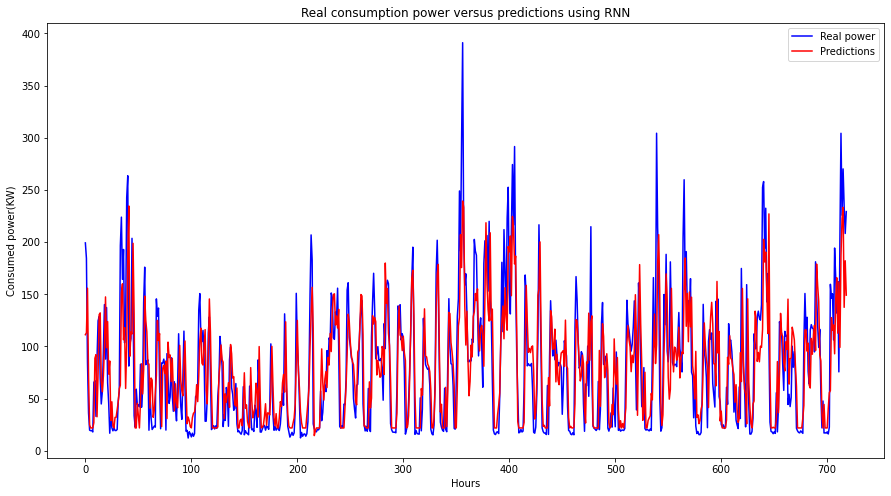

In [52]:
#visualization of Real power consumption  versus predictions by RNN using one month test data
fig= plt.figure(figsize=(15,8))
power_changes=fig.add_subplot(1,1,1)
power_changes.set_ylabel('Consumed power(KW)')
power_changes.set_xlabel('Hours')

power_changes.plot(test_data_rnn, color='blue', label='Real power')
power_changes.plot(predictions_rnn, color= 'red', label='Predictions')
power_changes.set_title('Real consumption power versus predictions using RNN')
power_changes.legend(loc='best')

In [53]:
#Calculating RMSE
def print_scores(y_test,y_pred):
    rmse= np.sqrt(mean_squared_error(y_test,y_pred))    
    return rmse
rmse=print_scores(predictions_rnn,test_data_rnn)
print(rmse)

39.5803241095926


### LSTM

In [75]:
scaler_lstm = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_lstm = scaler_lstm.fit_transform(trainX)
print("X_train_scaled shape after scaling by minmax scaler", X_train_scaled_lstm.shape)

Y_train_scaled_lstm= scaler_lstm.fit_transform(trainY)
print("Y_train_scaled shape after scaling by minmax scaler", Y_train_scaled_lstm.shape)

X_test_scaled_lstm = scaler_lstm.transform(testX)
print("X_train_scaled shape after scaling by minmax scaler", X_test_scaled_lstm.shape)

trainX_re_lstm = np.reshape(X_train_scaled_lstm, (X_train_scaled_lstm.shape[0], 1, X_train_scaled_lstm.shape[1]))
testX_re_lstm = np.reshape(X_test_scaled_lstm, (X_test_scaled_lstm.shape[0], 1, X_test_scaled_lstm.shape[1]))

print(trainX_re_lstm.shape, testX_re_lstm.shape)

X_train_scaled shape after scaling by minmax scaler (17519, 24)
Y_train_scaled shape after scaling by minmax scaler (17519, 1)
X_train_scaled shape after scaling by minmax scaler (719, 24)
(17519, 1, 24) (719, 1, 24)


In [76]:
@measureit
def lstm_model(X, Y, verbose=2):
    batch_size= 32
    model = Sequential()
    model.add(LSTM(216, activation='relu', input_shape=(1, look_back )))
    model.add(Dense(1))
    optimizer = keras.optimizers.Adam(lr=0.001, clipvalue=0.5)
    model.compile(loss="mse", optimizer=optimizer)
    model.fit(X, Y, epochs= 50, batch_size= batch_size, verbose=verbose) 
    return model

In [77]:

model_lstm=lstm_model(trainX_re_lstm, Y_train_scaled_lstm)

Epoch 1/50
548/548 - 2s - loss: 0.0114
Epoch 2/50
548/548 - 1s - loss: 0.0097
Epoch 3/50
548/548 - 1s - loss: 0.0094
Epoch 4/50
548/548 - 1s - loss: 0.0093
Epoch 5/50
548/548 - 1s - loss: 0.0093
Epoch 6/50
548/548 - 1s - loss: 0.0093
Epoch 7/50
548/548 - 1s - loss: 0.0092
Epoch 8/50
548/548 - 1s - loss: 0.0092
Epoch 9/50
548/548 - 1s - loss: 0.0092
Epoch 10/50
548/548 - 1s - loss: 0.0091
Epoch 11/50
548/548 - 1s - loss: 0.0091
Epoch 12/50
548/548 - 1s - loss: 0.0091
Epoch 13/50
548/548 - 1s - loss: 0.0090
Epoch 14/50
548/548 - 1s - loss: 0.0090
Epoch 15/50
548/548 - 1s - loss: 0.0090
Epoch 16/50
548/548 - 1s - loss: 0.0090
Epoch 17/50
548/548 - 1s - loss: 0.0089
Epoch 18/50
548/548 - 1s - loss: 0.0089
Epoch 19/50
548/548 - 1s - loss: 0.0089
Epoch 20/50
548/548 - 1s - loss: 0.0088
Epoch 21/50
548/548 - 1s - loss: 0.0088
Epoch 22/50
548/548 - 1s - loss: 0.0088
Epoch 23/50
548/548 - 1s - loss: 0.0087
Epoch 24/50
548/548 - 1s - loss: 0.0088
Epoch 25/50
548/548 - 1s - loss: 0.0087
Epoch 26/

In [57]:
testPredict_lstm= model_lstm.predict(testX_re_lstm)

In [58]:
inv_yhat = scaler_lstm.inverse_transform(testPredict_lstm)

predictions_lstm=to_series(inv_yhat)
test_data_lstm=to_series(testY)


In [59]:
#Calculating RMSE
def print_scores(y_test,y_pred):
    rmse= np.sqrt(mean_squared_error(y_test,y_pred))    
    return rmse
rmse=print_scores(predictions_lstm,test_data_lstm)
print(rmse)

40.80439774947916


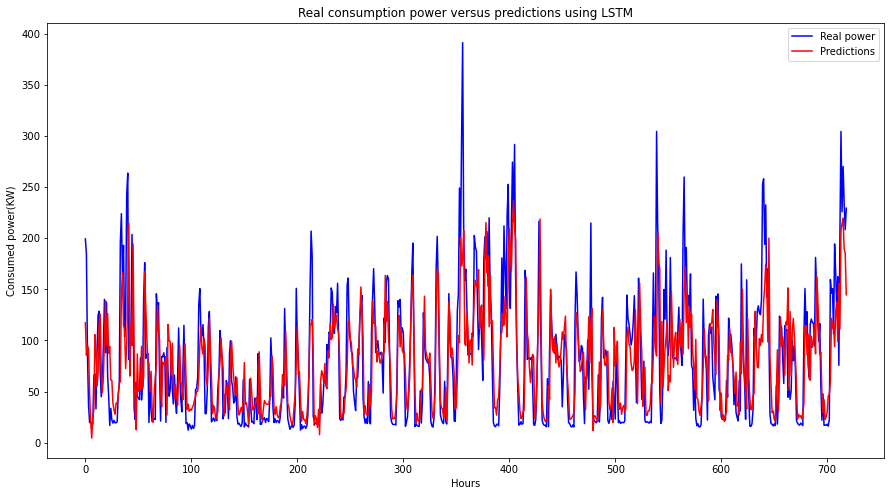

In [60]:
#visualization of Real power consumption  versus predictions by LSTM using one month test data
fig= plt.figure(figsize=(15,8))
power_changes=fig.add_subplot(1,1,1)
power_changes.set_ylabel('Consumed power(KW)')
power_changes.set_xlabel('Hours')

power_changes.plot(test_data_lstm, color='blue', label='Real power')
power_changes.plot(predictions_lstm, color= 'red', label='Predictions')
power_changes.set_title('Real consumption power versus predictions using LSTM')
power_changes.legend(loc='best')

## Memory and CPU utilization visualization

In [86]:
mem_df, cpu_df = prep_cpu_mem_df()

<BarContainer object of 4 artists>

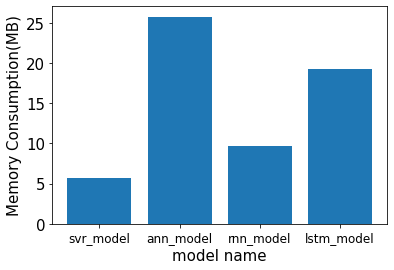

In [87]:
# memory usage visualization of a model 
plt.ylabel('Memory Consumption(MB)',fontsize=15)
plt.xlabel('model name',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.bar(mem_df.Model, mem_df.Val)

<BarContainer object of 4 artists>

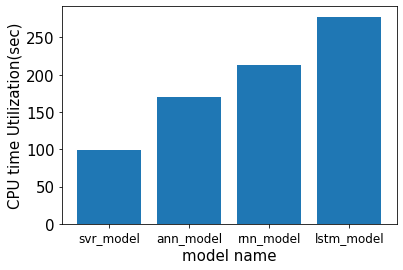

In [88]:
# cpu utilization visualization of a model
plt.ylabel('CPU time Utilization(sec)',fontsize=15)
plt.xlabel('model name',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=15)
plt.bar(cpu_df.Model, cpu_df.Val)